In [ ]:
!pip install cvxpy

In [ ]:
# Only run once!!
import os

os.chdir("../src/")

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names
from samplers import get_data_sampler
from tasks import get_task_sampler, SparseLinearRegression
from tasks import LinearRegression as LinearRegressionTask


import matplotlib as mpl
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, SGDRegressor, Ridge
import numpy as np
import cvxpy
from cvxpy import Variable, Minimize, Problem
from cvxpy import norm as cvxnorm

# from cvxpy import mul_elemwise, SCS
from cvxpy import vec as cvxvec

%matplotlib inline

sns.set_theme("notebook", "darkgrid")
palette = sns.color_palette("colorblind")
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["text.usetex"] = True

matplotlib.rcParams.update(
    {
        "axes.titlesize": 8,
        "figure.titlesize": 10,  # was 10
        "legend.fontsize": 10,  # was 10
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
    }
)
run_dir = " ../models/"

In [3]:
SPINE_COLOR = "gray"


def format_axes(ax):
    for spine in ["top", "right"]:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    for spine in ["left", "bottom"]:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction="out", color=SPINE_COLOR)
    return ax

In [4]:
lr_svr_mixture_path = "../models/two_task_mixer/final_model_dr_svr"  # Change according to the id of the model you train
lr_single_path = "../models/linear_regression/final_model_w_posenc"  # Change according to the id of the model you train
svr_single_path = "../models/sign_vec_cs/final_model_w_posenc"  # Change according to the id of the model you train


lr_svr_model, lr_sr_conf = get_model_from_run(lr_svr_mixture_path)
lr_model, lr_conf = get_model_from_run(lr_single_path)
svr_model, svr_conf = get_model_from_run(svr_single_path)

lr_svr_model.to("cuda:0")
lr_model.to("cuda:0")
svr_model.to("cuda:0")

TransformerModel(
  (_read_in): Linear(in_features=20, out_features=256, bias=True)
  (_backbone): GPT2Model(
    (wte): Embedding(50257, 256)
    (wpe): Embedding(202, 256)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropou

In [5]:
batch_size = 1280  # 1280 #conf.training.batch_size
n_dims = 20
n_points = lr_sr_conf.training.curriculum.points.end
data_sampler = get_data_sampler(lr_sr_conf.training.data, n_dims)
task_sampler = get_task_sampler(
    lr_sr_conf.training.task, n_dims, batch_size, **lr_sr_conf.training.task_kwargs
)

In [6]:
seed = 42
torch.manual_seed(seed)
# lr_sr_conf.training.task_kwargs.update({"normalize_outputs": True})
lr_conf.training.task_kwargs.update({"normalize_outputs": True})
svr_conf.training.task_kwargs.update({"normalize_outputs": True})

# mix_task = get_task_sampler(
#     lr_sr_conf.training.task,
#     n_dims,
#     batch_size,
#     **lr_sr_conf.training.task_kwargs
# )()

lr_task = get_task_sampler(
    lr_conf.training.task, n_dims, batch_size, **lr_conf.training.task_kwargs
)()

svr_task = get_task_sampler(
    svr_conf.training.task, n_dims, batch_size, **svr_conf.training.task_kwargs
)()

xs = data_sampler.sample_xs(b_size=batch_size, n_points=n_points)

lr_ys = lr_task.evaluate(xs)
svr_ys = svr_task.evaluate(xs)

In [7]:
svr_task.normalize_outputs

True

In [8]:
svr_ys.max()

tensor(4.0651)

In [9]:
# lr_task = LinearRegressionTask(n_dims, batch_size, normalize_outputs = True)

# sr_task = SparseLinearRegression(n_dims, batch_size,
#                                  sparsity = sr_conf.training.task_kwargs["sparsity"],
#                                  normalize_outputs = True)

In [10]:
with torch.no_grad():
    print("Getting LR Preds for Mixture Model")
    mix_transformer_lr_preds = lr_svr_model(xs.to("cuda:0"), lr_ys.to("cuda:0")).cpu()
    print("Getting SVR Preds for Mixture Model")
    mix_transformer_svr_preds = lr_svr_model(xs.to("cuda:0"), svr_ys.to("cuda:0")).cpu()
    print("Getting LR Preds for LR Model")
    lr_transformer_lr_preds = lr_model(xs.to("cuda:0"), lr_ys.to("cuda:0")).cpu()
    print("Getting SVR Preds for SVR Model")
    svr_transformer_svr_preds = svr_model(xs.to("cuda:0"), svr_ys.to("cuda:0")).cpu()
    print("Getting LR Preds for SVR Model")
    svr_transformer_lr_preds = svr_model(xs.to("cuda:0"), lr_ys.to("cuda:0")).cpu()
    print("Getting SVR Preds for LR Model")
    lr_transformer_svr_preds = lr_model(xs.to("cuda:0"), svr_ys.to("cuda:0")).cpu()

Getting LR Preds for Mixture Model
Getting SVR Preds for Mixture Model
Getting LR Preds for LR Model
Getting SVR Preds for SVR Model
Getting LR Preds for SVR Model
Getting SVR Preds for LR Model


In [11]:
metric = lr_task.get_metric()
mix_transformer_lr_errors = metric(mix_transformer_lr_preds, lr_ys).numpy().squeeze()
mix_transformer_svr_errors = metric(mix_transformer_svr_preds, svr_ys).numpy().squeeze()
lr_transformer_lr_errors = metric(lr_transformer_lr_preds, lr_ys).numpy().squeeze()
svr_transformer_svr_errors = metric(svr_transformer_svr_preds, svr_ys).numpy().squeeze()
svr_transformer_lr_errors = metric(svr_transformer_lr_preds, lr_ys).numpy().squeeze()
lr_transformer_svr_errors = metric(lr_transformer_svr_preds, svr_ys).numpy().squeeze()

In [14]:
def get_lsq_pred_nd_errors(xs, ys):
    lsq_preds = [np.zeros(xs.shape[0])]
    lsq_weights = []
    for i in tqdm(range(1, xs.shape[1])):
        preds = []
        weights = []
        for batch_id in range(xs.shape[0]):
            lsq_model = LinearRegression(fit_intercept=False)
            preds.append(
                lsq_model.fit(xs[batch_id, :i], ys[batch_id, :i]).predict(
                    xs[batch_id, i : i + 1]
                )[0]
            )
            weights.append(lsq_model.coef_)
        preds = np.array(preds).squeeze()
        lsq_preds.append(preds)
        lsq_weights.append(weights)
    lsq_preds = np.array(lsq_preds)
    lsq_preds = torch.tensor(lsq_preds.T).float()
    lsq_errors = metric(lsq_preds, ys).numpy().squeeze()
    lsq_weights = np.array(lsq_weights)

    return lsq_preds, lsq_errors, torch.tensor(lsq_weights).float()

In [45]:
# print("Getting Errors for LR Prompts")
# _, ols_lr_errors, ols_lr_weights = get_lsq_pred_nd_errors(xs, lr_ys)
print("Getting Errors for SVR Prompts")
_, ols_svr_errors, ols_svr_weights = get_lsq_pred_nd_errors(xs, svr_ys)

Getting Errors for SVR Prompts


  0%|          | 0/40 [00:00<?, ?it/s]

In [15]:
ols_lr_errors.shape

(1280, 41)

In [23]:
def get_linf_pred_nd_errors(xs, ys):
    linf_norm_preds = []
    w_stars = []
    for b in tqdm(range(xs.shape[0])):
        preds = [0]
        weights = []
        for t in range(xs.shape[1] - 1):
            w_star = Variable([n_dims, 1])
            obj = Minimize(cvxnorm(w_star, "inf"))
            constraints = [
                ys[b, : t + 1].numpy()[:, np.newaxis]
                == (xs[b, : t + 1].numpy() @ w_star)
            ]
            prob = Problem(obj, constraints)
            result = prob.solve()
            try:
                pred = w_star.value[:, 0] @ xs[b, t + 1].numpy()
                weights.append(w_star.value)
            except:
                pred = 0
                weights.append(weights[-1])

            preds.append(pred)
        linf_norm_preds.append(preds)
        w_stars.append(weights)
    #     baseline_errors_batch.append(errors)
    # np.mean(errors)
    linf_norm_preds = torch.tensor(linf_norm_preds).float()
    linf_norm_errors = metric(linf_norm_preds, ys).numpy().squeeze()
    linf_norm_weights = torch.tensor(w_stars)

    return linf_norm_preds, linf_norm_errors, linf_norm_weights

In [49]:
# print("Getting Errors for SVR Prompts")
_, linf_svr_errors, linf_svr_weights = get_linf_pred_nd_errors(xs, svr_ys)
print("Getting Errors for LR Prompts")
_, linf_lr_errors, linf_lr_weights = get_linf_pred_nd_errors(xs, lr_ys)

  0%|          | 0/1280 [00:00<?, ?it/s]

Getting Errors for LR Prompts


  0%|          | 0/1280 [00:00<?, ?it/s]

In [47]:
def get_df_from_pred_array(pred_arr, n_points, offset=0):
    # pred_arr --> b x pts-1
    batch_size = pred_arr.shape[0]
    flattened_arr = pred_arr.ravel()
    points = np.array(list(range(offset, n_points)) * batch_size)
    df = pd.DataFrame({"y": flattened_arr, "x": points})
    return df


def lineplot_with_ci(pred_or_err_arr, n_points, offset, label, ax, seed):
    sns.lineplot(
        data=get_df_from_pred_array(pred_or_err_arr, n_points=n_points, offset=offset),
        y="y",
        x="x",
        label=label,
        ax=ax,
        n_boot=1000,
        seed=seed,
        ci=90,
    )

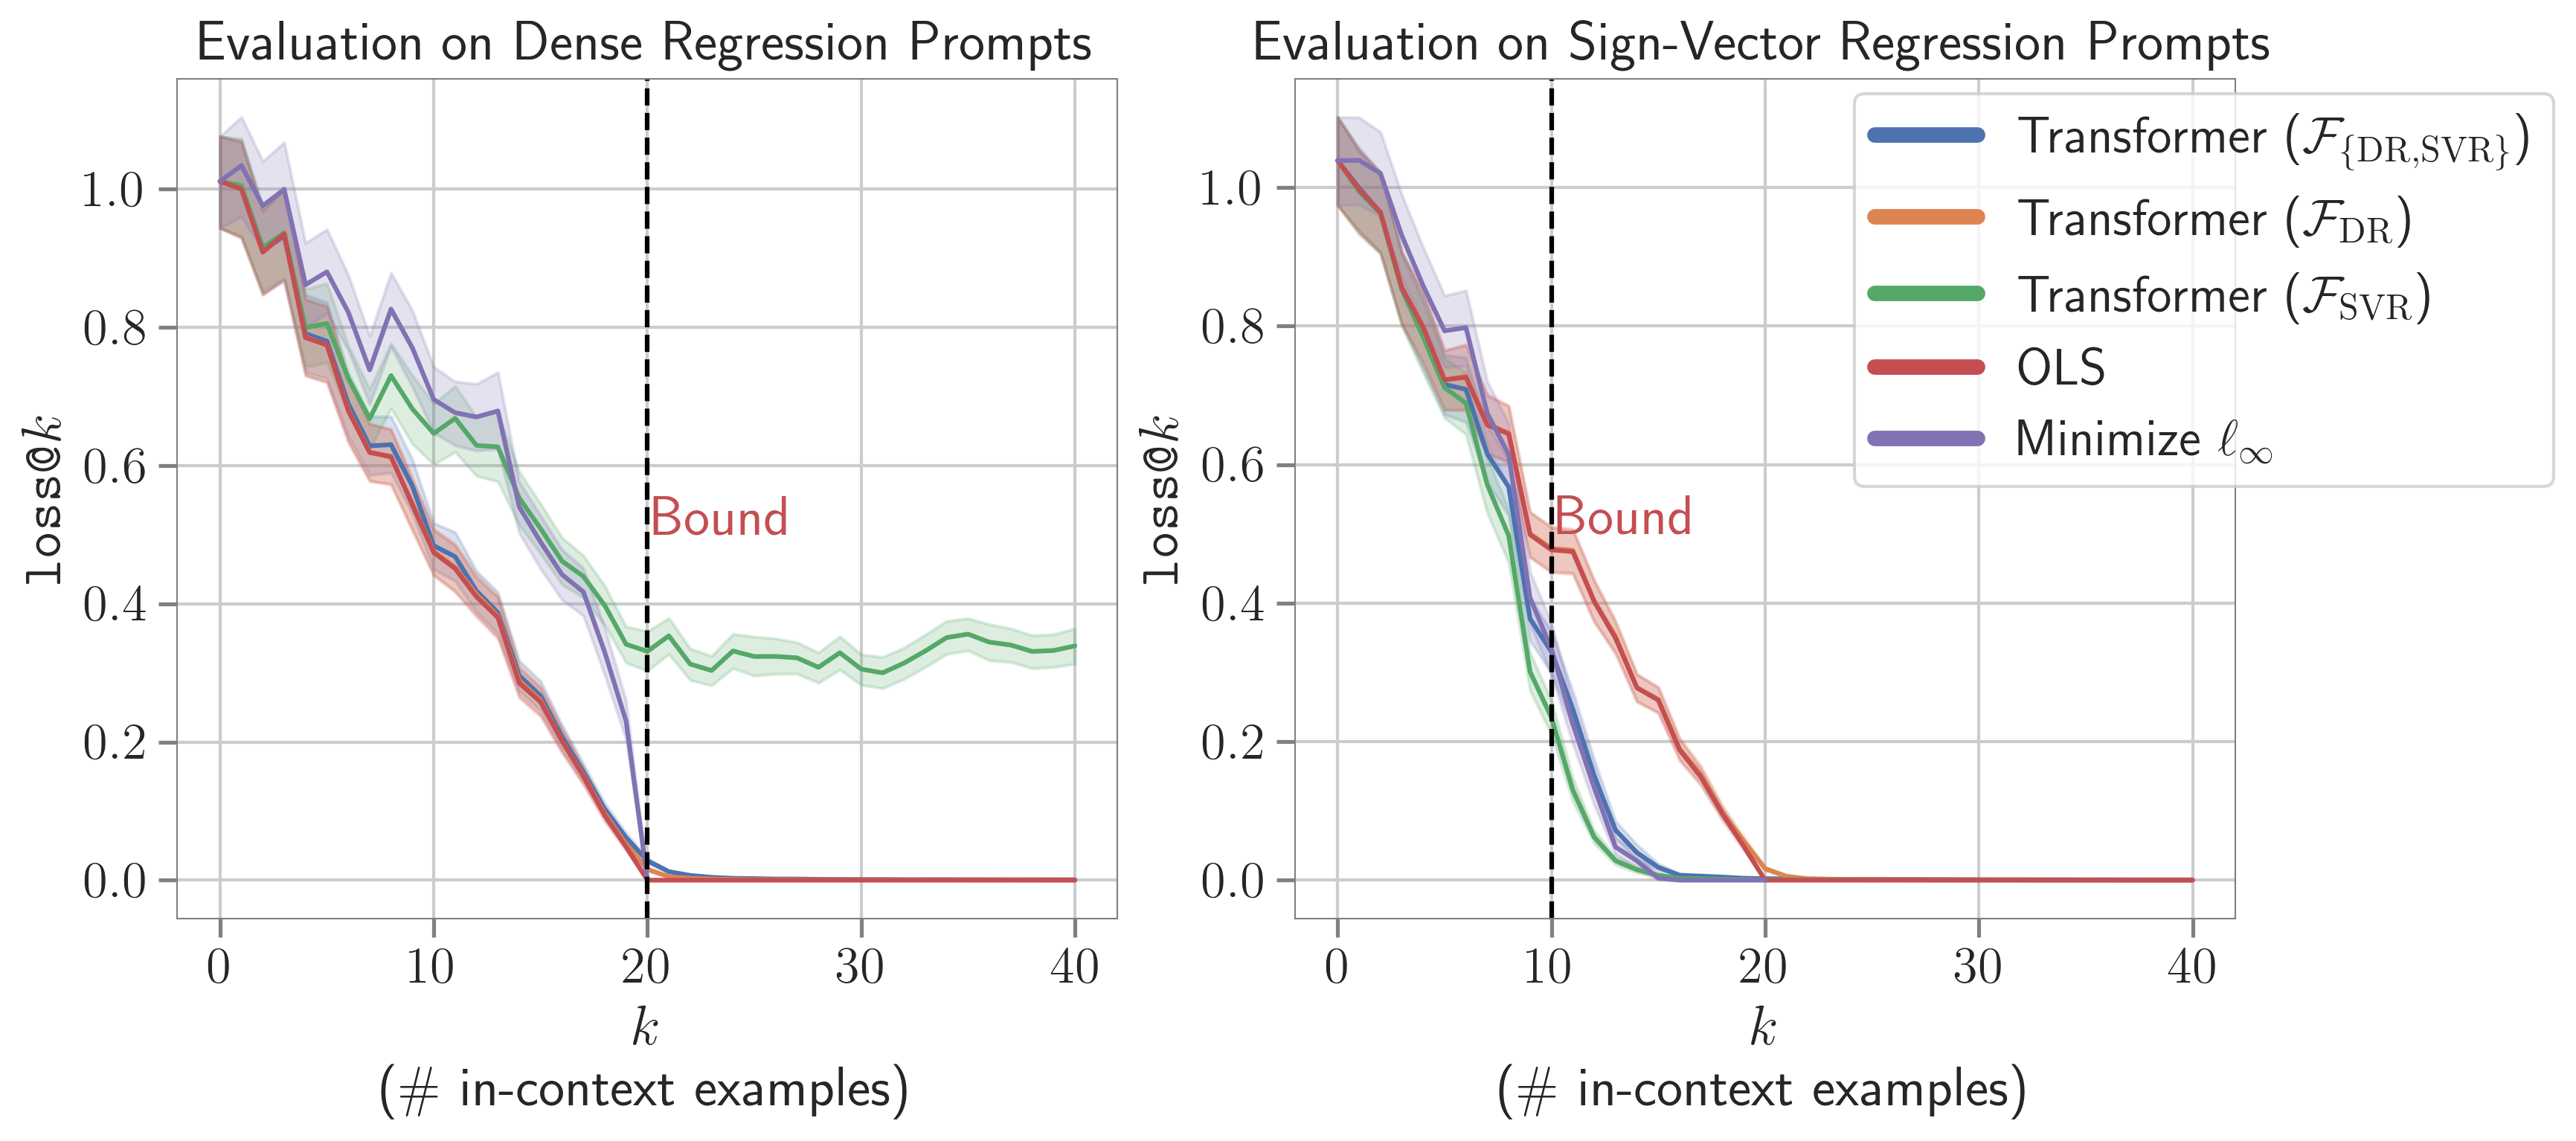

In [45]:
sns.set(style="whitegrid", font_scale=1.5)
# latexify(4, 3)

lr_bound = n_dims
svr_bound = n_dims // 2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
# ax.plot(list(range(n_points)), transformer_pe_errors.mean(axis=0), label = "With Position Encodings")
# ax.plot(list(range(n_points)), transformer_no_pe_errors.mean(axis=0), label = "Without Position Encodings")
lineplot_with_ci(
    mix_transformer_lr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\{\mathrm{DR},\mathrm{SVR}\}}$)",
    ax=ax1,
    seed=seed,
)
lineplot_with_ci(
    lr_transformer_lr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{DR}}$)",
    ax=ax1,
    seed=seed,
)
lineplot_with_ci(
    svr_transformer_lr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{SVR}}$)",
    ax=ax1,
    seed=seed,
)
lineplot_with_ci(ols_lr_errors, n_points, offset=0, label="OLS", ax=ax1, seed=seed)
lineplot_with_ci(
    linf_lr_errors[:, : n_dims + 1],
    n_dims + 1,
    offset=0,
    label="Minimize $\ell_{\infty}$",
    ax=ax1,
    seed=seed,
)
# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax1.set_xlabel("$k$\n(\# in-context examples)")
ax1.set_ylabel("$\\texttt{loss@}k$")
ax1.set_title("Evaluation on Dense Regression Prompts")
ax1.axvline(lr_bound, ls="--", color="black")
ax1.annotate("Bound", xy=(lr_bound + 0.25, 0.5), color="r", rotation=0)
format_axes(ax1)

lineplot_with_ci(
    mix_transformer_svr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\{\mathrm{DR},\mathrm{SVR}\}}$)",
    ax=ax2,
    seed=seed,
)
lineplot_with_ci(
    lr_transformer_svr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{DR}}$)",
    ax=ax2,
    seed=seed,
)
lineplot_with_ci(
    svr_transformer_svr_errors,
    n_points,
    offset=0,
    label="Transformer ($\mathcal{F}_{\mathrm{SVR}}$)",
    ax=ax2,
    seed=seed,
)
lineplot_with_ci(ols_svr_errors, n_points, offset=0, label="OLS", ax=ax2, seed=seed)
lineplot_with_ci(
    linf_svr_errors[:, : n_dims + 1],
    n_dims + 1,
    offset=0,
    label="Minimize $\ell_{\infty}$",
    ax=ax2,
    seed=seed,
)
# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax2.set_xlabel("$k$\n(\# in-context examples)")
ax2.set_ylabel("$\\texttt{loss@}k$")
ax2.set_title("Evaluation on Sign-Vector Regression Prompts")
ax2.axvline(svr_bound, ls="--", color="black")
ax2.annotate("Bound", xy=(svr_bound + 0.25, 0.5), color="r", rotation=0)
format_axes(ax2)

ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
handles, labels = ax1.get_legend_handles_labels()
leg = fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 0.95))
# leg = plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1))
for line in leg.get_lines():
    line.set_linewidth(5)
plt.savefig("final_plots/lr_svr_mix_errors.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [26]:
def recover_weights_pv2(model, xs, ys, w_b, data_sampler):
    model.to("cuda:0")
    batch_size = xs.size(0)
    n_dims = w_b.size(1)

    x_probes = data_sampler.sample_xs(b_size=xs.shape[0], n_points=2 * xs.shape[-1] + 1)
    y_probes = []
    for i in range(2 * xs.shape[-1] + 1):
        x_prompt = torch.concat([xs, x_probes[:, i : i + 1, :]], axis=1)
        y_prompt = torch.concat([ys, torch.zeros(xs.shape[0], 1)], axis=1)
        with torch.no_grad():
            pred = model(x_prompt.to("cuda:0"), y_prompt.to("cuda:0")).cpu()
        y_probes.append(pred[:, -1:])

    y_probes = torch.cat(y_probes, axis=1)
    w_probed = []

    for batch in range(len(x_probes)):
        x, y = x_probes[batch], y_probes[batch]
        probe_model = LinearRegression(fit_intercept=False)
        probe_model.fit(x, y)
        w_probed.append(torch.tensor(probe_model.coef_[np.newaxis]).float())

    w_probed = torch.cat(w_probed, axis=0)
    error = ((w_probed - w_b[:, :, 0]) ** 2).mean(axis=1).mean()
    cos_sim = torch.nn.CosineSimilarity(dim=1, eps=1e-6)(w_probed, w_b[:, :, 0]).mean()

    return w_b, w_probed, error, cos_sim

In [28]:
w_b, mix_w_lr_probed, error, cos_sim = recover_weights_pv2(
    lr_svr_model, xs[:, :-1], lr_ys[:, :-1], lr_task.w_b, data_sampler
)

In [29]:
cos_sim

tensor(0.9997)

In [30]:
mix_w_lr_probed_vecs = []
for n_points_i in tqdm(range(1, n_points)):
    _, w_probed, _, cos_sim = recover_weights_pv2(
        lr_svr_model,
        xs[:, :n_points_i],
        lr_ys[:, :n_points_i],
        lr_task.w_b,
        data_sampler,
    )
    mix_w_lr_probed_vecs.append(w_probed)

  0%|          | 0/40 [00:00<?, ?it/s]

In [31]:
mix_w_svr_probed_vecs = []
for n_points_i in tqdm(range(1, n_points)):
    _, w_probed, _, cos_sim = recover_weights_pv2(
        lr_svr_model,
        xs[:, :n_points_i],
        svr_ys[:, :n_points_i],
        svr_task.w_b,
        data_sampler,
    )
    mix_w_svr_probed_vecs.append(w_probed)

  0%|          | 0/40 [00:00<?, ?it/s]

In [32]:
lr_w_lr_probed_vecs = []
for n_points_i in tqdm(range(1, n_points)):
    _, w_probed, _, cos_sim = recover_weights_pv2(
        lr_model, xs[:, :n_points_i], lr_ys[:, :n_points_i], lr_task.w_b, data_sampler
    )
    lr_w_lr_probed_vecs.append(w_probed)

  0%|          | 0/40 [00:00<?, ?it/s]

In [33]:
svr_w_svr_probed_vecs = []
for n_points_i in tqdm(range(1, n_points)):
    _, w_probed, _, cos_sim = recover_weights_pv2(
        svr_model,
        xs[:, :n_points_i],
        svr_ys[:, :n_points_i],
        svr_task.w_b,
        data_sampler,
    )
    svr_w_svr_probed_vecs.append(w_probed)

  0%|          | 0/40 [00:00<?, ?it/s]

In [51]:
import math

s = 3
mse_mix_trans_lr_lsq = []
mse_mix_trans_lr_linf = []
mse_mix_trans_svr_lsq = []
mse_mix_trans_svr_linf = []

mse_mix_trans_lr_lr_trans = []
mse_mix_trans_svr_svr_trans = []

mse_mix_trans_lr_gold = []
mse_mix_trans_svr_gold = []

lr_gold_weights = lr_task.w_b.squeeze() / math.sqrt(n_dims)
svr_gold_weights = svr_task.w_b.squeeze() / math.sqrt(s)
for n_points_i in tqdm(range(1, n_points)):
    mix_trans_lr_weight_vect = mix_w_lr_probed_vecs[n_points_i - 1].squeeze()
    mix_trans_svr_weight_vect = mix_w_svr_probed_vecs[n_points_i - 1].squeeze()
    lsq_lr_weight_vect = ols_lr_weights[n_points_i - 1].squeeze()
    lsq_svr_weight_vect = ols_svr_weights[n_points_i - 1].squeeze()
    lr_trans_lr_weight_vect = lr_w_lr_probed_vecs[n_points_i - 1].squeeze()
    svr_trans_svr_weight_vect = svr_w_svr_probed_vecs[n_points_i - 1].squeeze()

    linf_lr_weight_vect = torch.tensor(linf_lr_weights)[:, n_points_i - 1].squeeze()
    linf_svr_weight_vect = torch.tensor(linf_svr_weights)[:, n_points_i - 1].squeeze()

    mse_mix_trans_lr_lsq.append(
        (n_dims * (mix_trans_lr_weight_vect - lsq_lr_weight_vect) ** 2).mean(axis=-1)
    )
    mse_mix_trans_lr_linf.append(
        (n_dims * (mix_trans_lr_weight_vect - linf_lr_weight_vect) ** 2).mean(axis=-1)
    )
    mse_mix_trans_svr_lsq.append(
        (s * (mix_trans_svr_weight_vect - lsq_svr_weight_vect) ** 2).mean(axis=-1)
    )
    mse_mix_trans_svr_linf.append(
        (s * (mix_trans_svr_weight_vect - linf_svr_weight_vect) ** 2).mean(axis=-1)
    )

    mse_mix_trans_lr_lr_trans.append(
        (n_dims * (mix_trans_lr_weight_vect - lr_trans_lr_weight_vect) ** 2).mean(
            axis=-1
        )
    )
    mse_mix_trans_svr_svr_trans.append(
        (n_dims * (mix_trans_svr_weight_vect - svr_trans_svr_weight_vect) ** 2).mean(
            axis=-1
        )
    )

    mse_mix_trans_lr_gold.append(
        (n_dims * (mix_trans_lr_weight_vect - lr_gold_weights) ** 2).mean(axis=-1)
    )
    mse_mix_trans_svr_gold.append(
        (s * (mix_trans_svr_weight_vect - svr_gold_weights) ** 2).mean(axis=-1)
    )


#     lsq_weight_vect = lsq_weights[:, n_points_i - 1].squeeze()
#     lasso_weight_vect = lasso_weights[:, n_points_i - 1].squeeze()
#     l1_min_weight_vect = l1_norm_weights[:, min(n_points_i - 1, l1_norm_weights.shape[1] - 1)].squeeze()

#     mse_trans_lsq.append(((trans_weight_vect - lsq_weight_vect)**2).mean(axis = -1))
#     mse_trans_lasso.append(((trans_weight_vect - lasso_weight_vect)**2).mean(axis = -1))
#     mse_trans_l1min.append(((trans_weight_vect - l1_min_weight_vect)**2).mean(axis = -1))
#     mse_trans_gold.append(((trans_weight_vect - gold_weights.squeeze())**2).mean(axis = -1))

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipykernel_3399/1938253812.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  linf_lr_weight_vect = torch.tensor(linf_lr_weights)[:,n_points_i - 1].squeeze()
/tmp/ipykernel_3399/1938253812.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  linf_svr_weight_vect = torch.tensor(linf_svr_weights)[:,n_points_i - 1].squeeze()


In [52]:
mse_mix_trans_lr_lsq = torch.vstack(mse_mix_trans_lr_lsq).transpose(0, 1)
mse_mix_trans_lr_linf = torch.vstack(mse_mix_trans_lr_linf).transpose(0, 1)
mse_mix_trans_svr_lsq = torch.vstack(mse_mix_trans_svr_lsq).transpose(0, 1)
mse_mix_trans_svr_linf = torch.vstack(mse_mix_trans_svr_linf).transpose(0, 1)

mse_mix_trans_lr_lr_trans = torch.vstack(mse_mix_trans_lr_lr_trans).transpose(0, 1)
mse_mix_trans_svr_svr_trans = torch.vstack(mse_mix_trans_svr_svr_trans).transpose(0, 1)

mse_mix_trans_lr_gold = torch.vstack(mse_mix_trans_lr_gold).transpose(0, 1)
mse_mix_trans_svr_gold = torch.vstack(mse_mix_trans_svr_gold).transpose(0, 1)

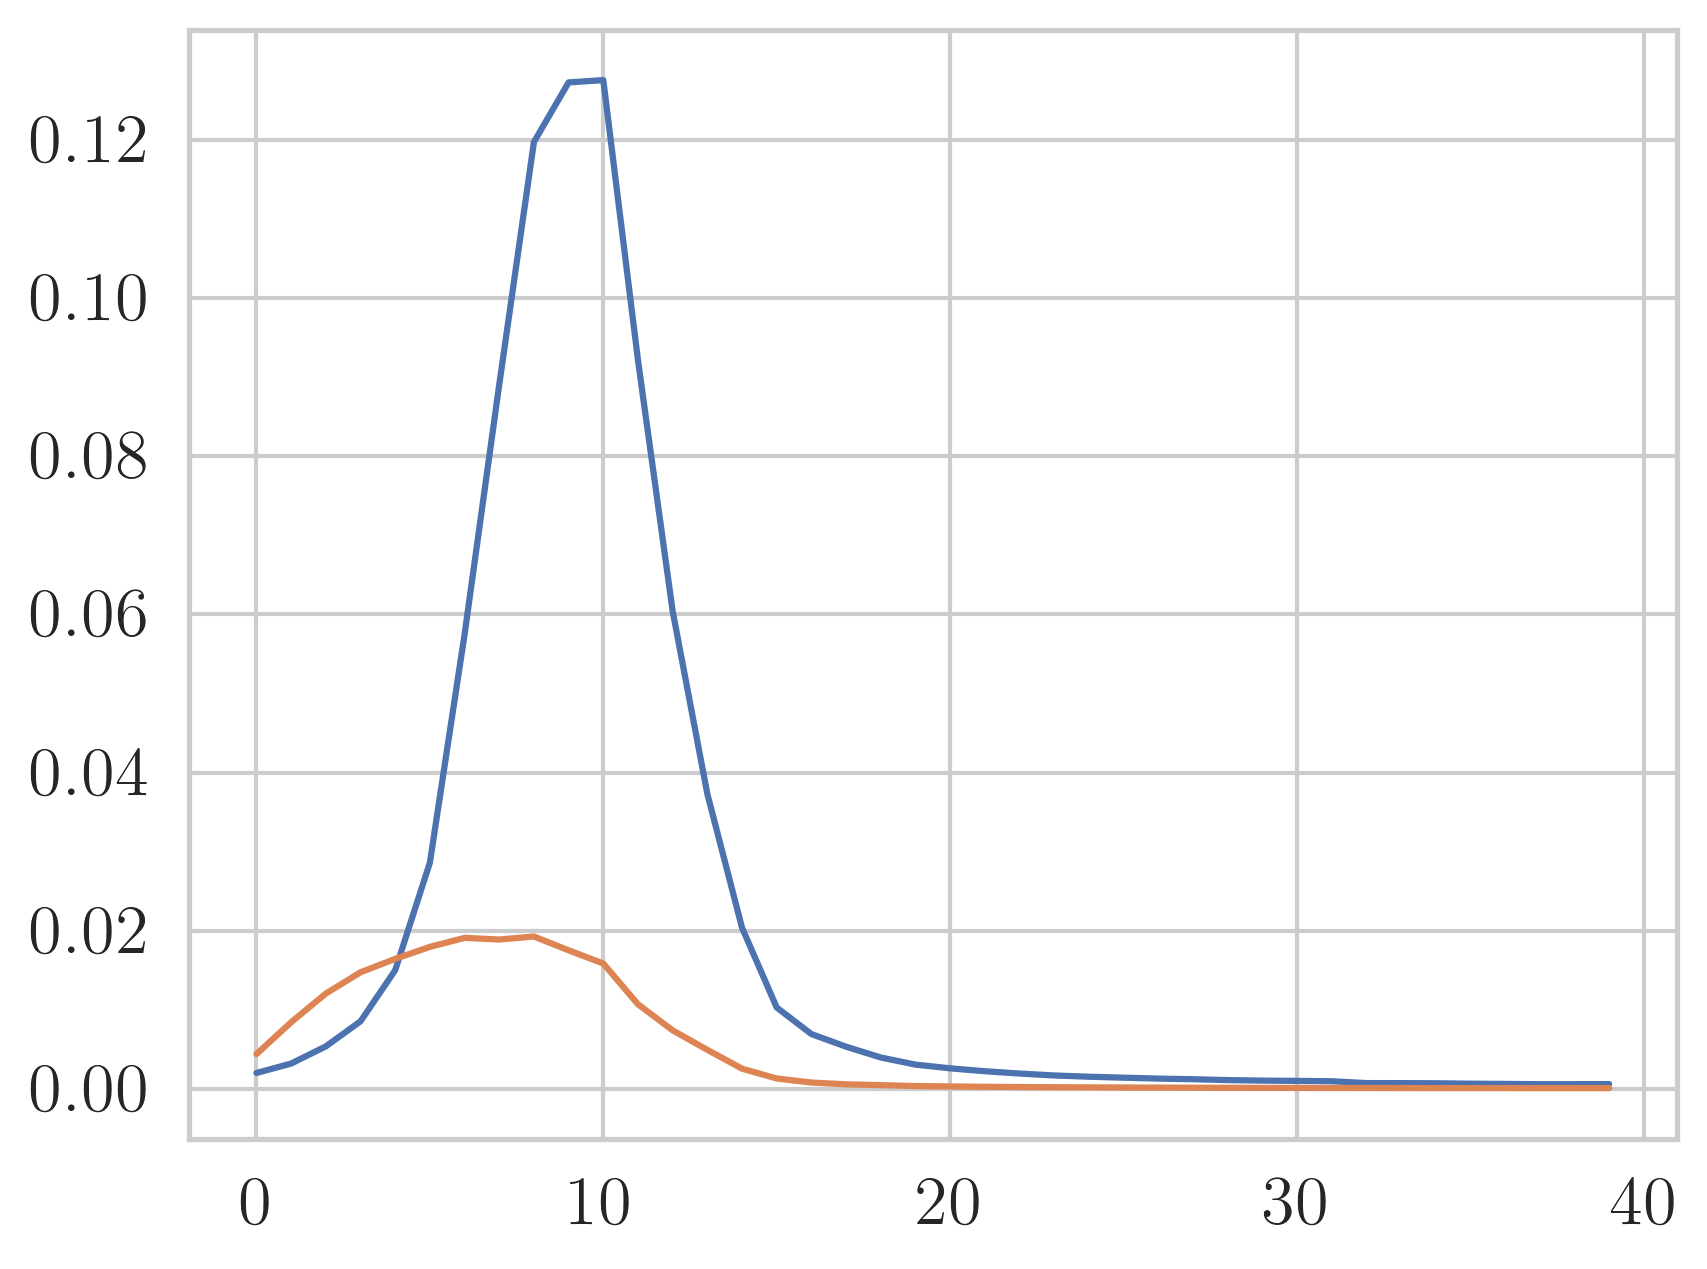

In [53]:
plt.plot(mse_mix_trans_svr_svr_trans.mean(0))
plt.plot(mse_mix_trans_svr_linf.mean(0))

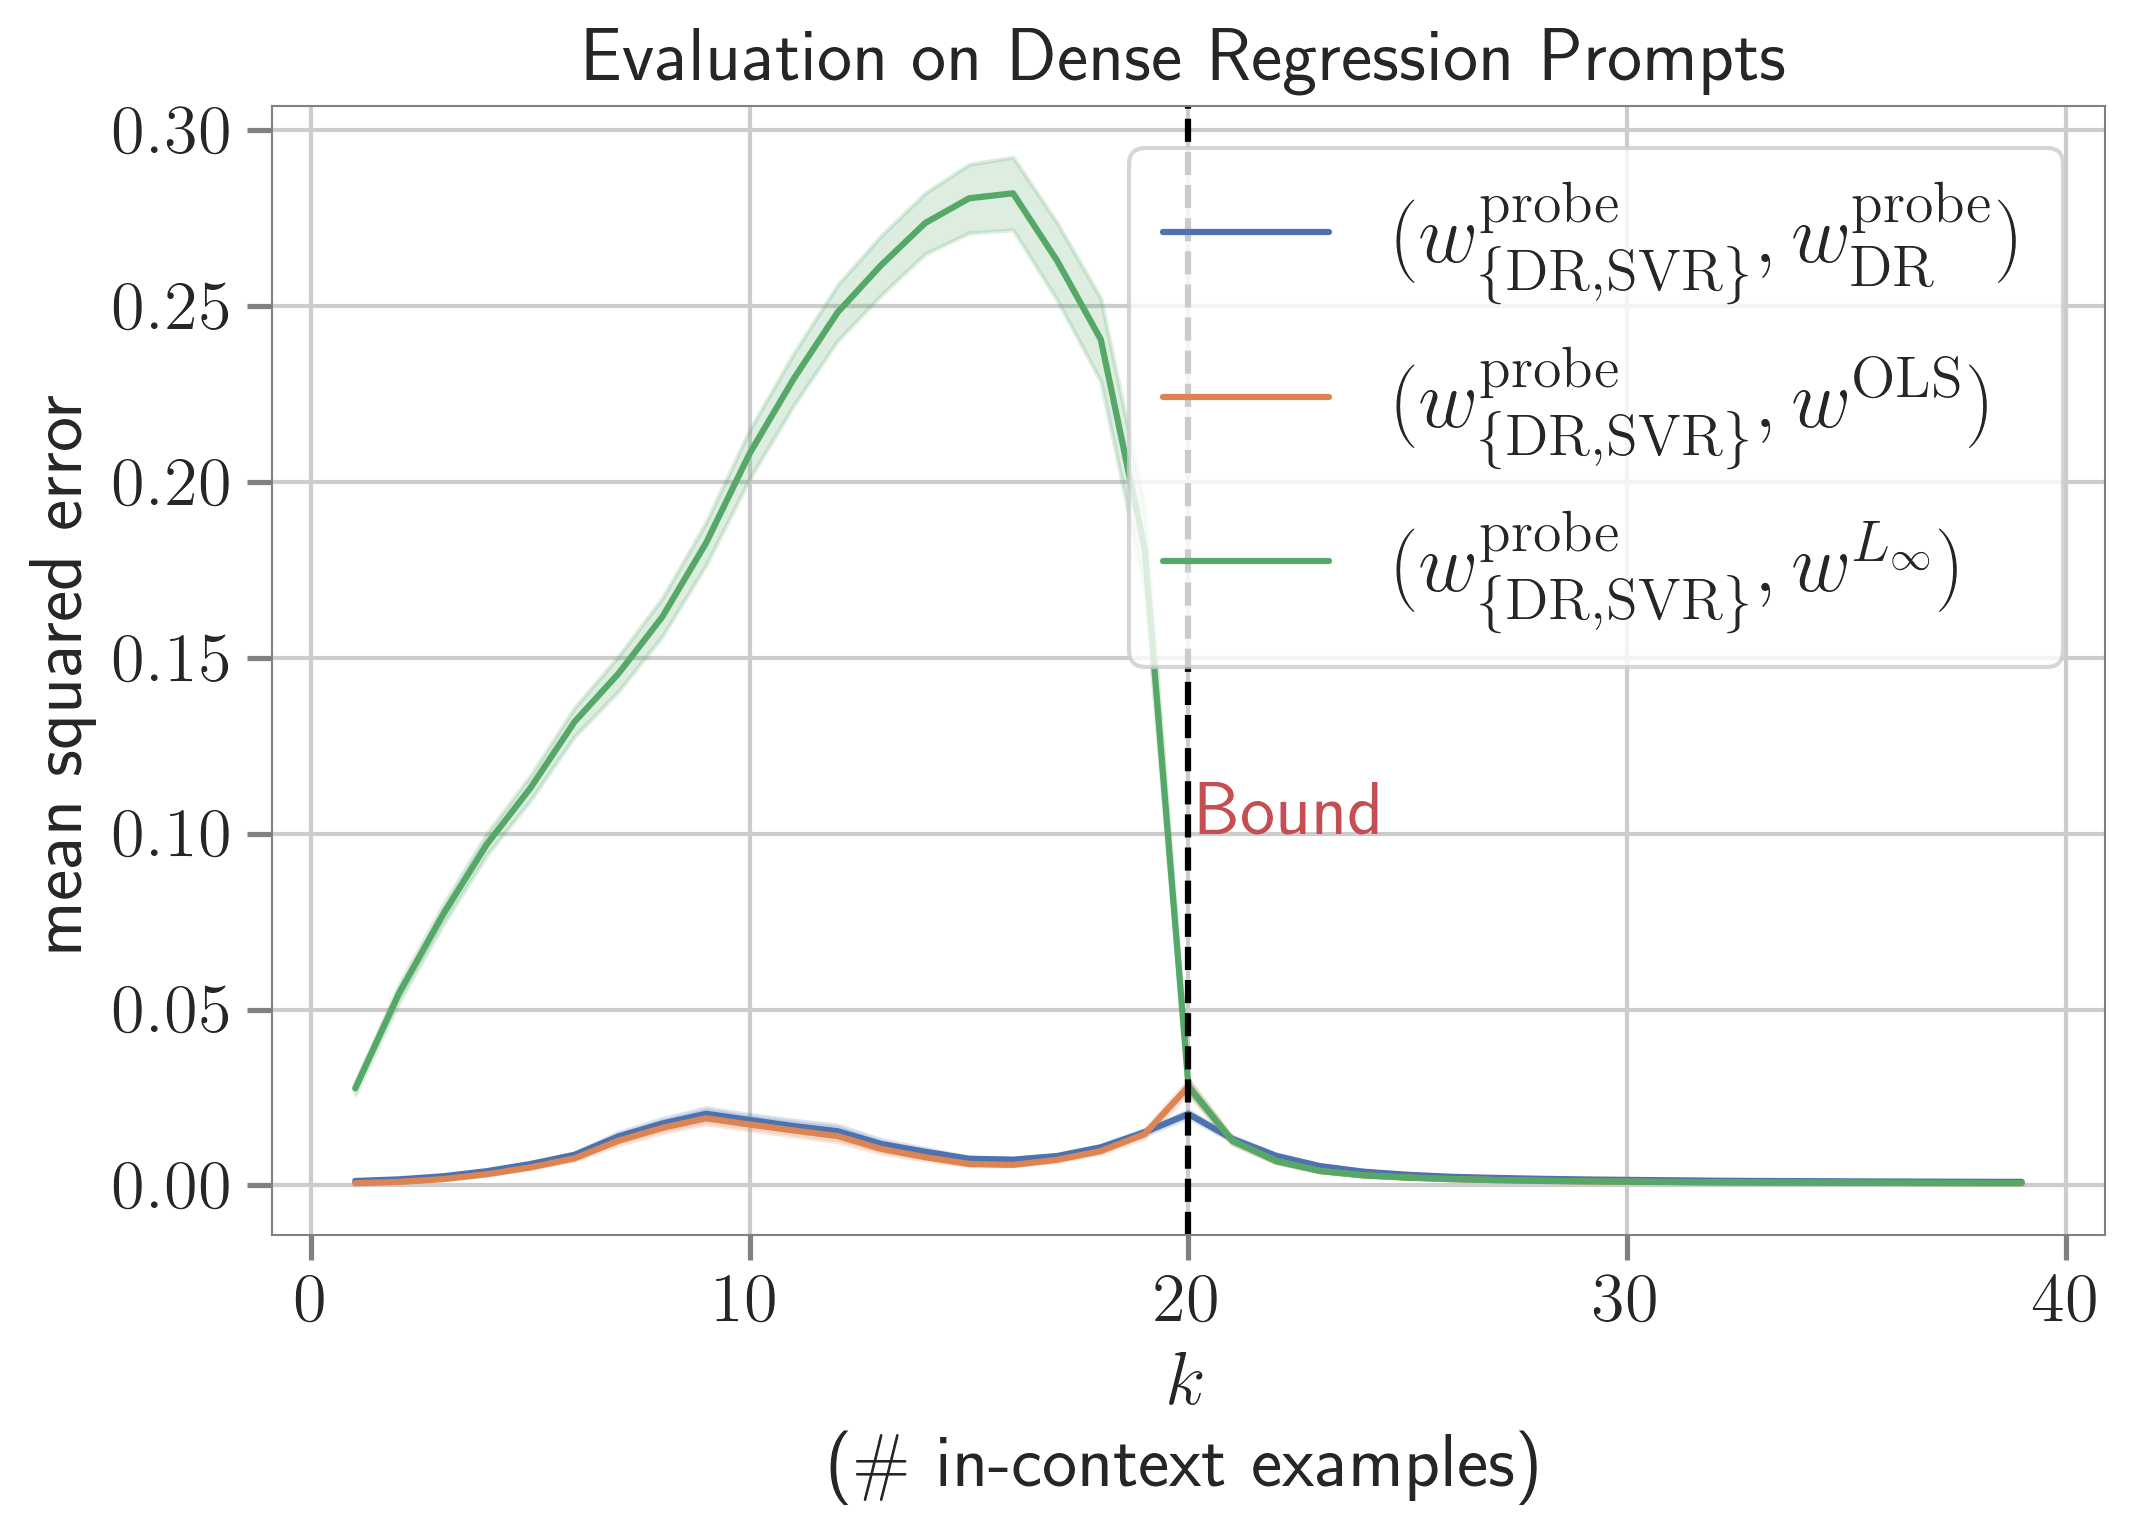

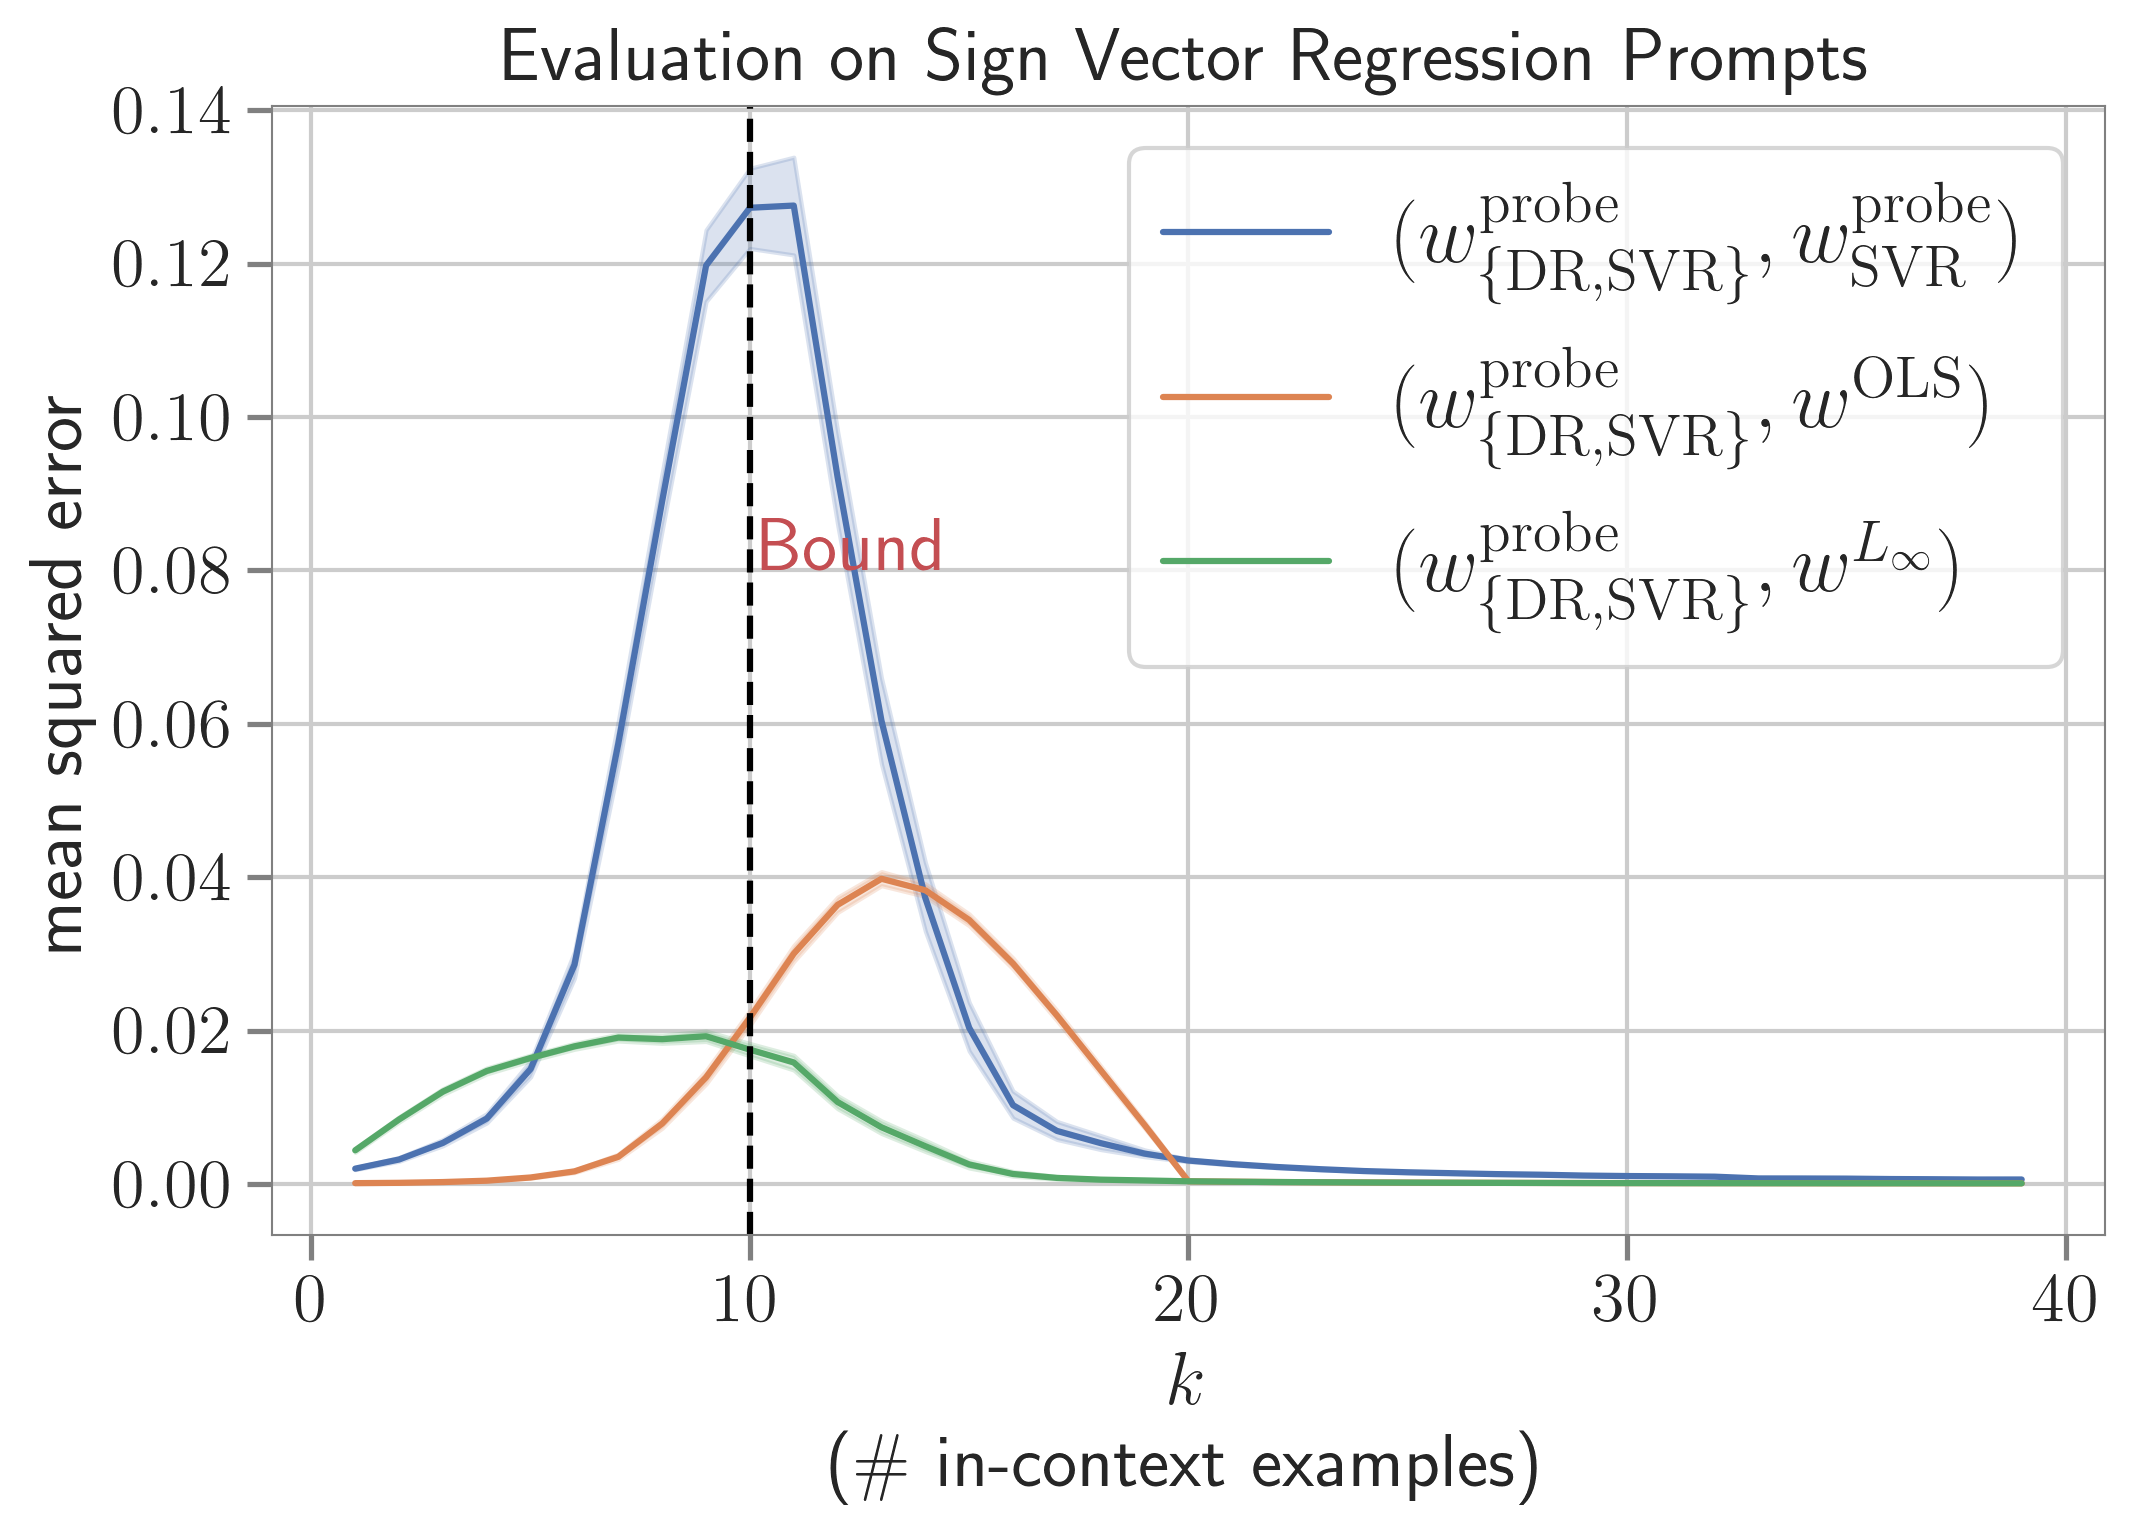

In [55]:
lr_bound = 20
svr_bound = lr_bound // 2

sns.set(style="whitegrid", font_scale=1.5)
# latexify(4, 3)

fig, ax1 = plt.subplots(1, 1, figsize=(7, 5), constrained_layout=True)

# ax.plot(list(range(n_points)), transformer_pe_errors.mean(axis=0), label = "With Position Encodings")
# ax.plot(list(range(n_points)), transformer_no_pe_errors.mean(axis=0), label = "Without Position Encodings")
lineplot_with_ci(
    mse_mix_trans_lr_lr_trans[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}_{\mathrm{\{DR, SVR\}}},w^{\mathrm{probe}}_{\mathrm{DR}})$",
    ax=ax1,
    seed=seed,
)
lineplot_with_ci(
    mse_mix_trans_lr_lsq[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}_{\mathrm{\{DR, SVR\}}}, w^{\mathrm{OLS}})$",
    ax=ax1,
    seed=seed,
)
lineplot_with_ci(
    mse_mix_trans_lr_linf[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}_{\mathrm{\{DR, SVR\}}}, w^{L_{\infty}})$",
    ax=ax1,
    seed=seed,
)
# lineplot_with_ci(cos_sims_linf_gold[:,:-1], n_points - 1,offset = 1, label="$(w^{\ell_{\infty}}, w)$", ax=ax, seed=seed)

# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax1.set_xlabel("$k$\n(\# in-context examples)")
ax1.set_ylabel("mean squared error")
ax1.set_title("Evaluation on Dense Regression Prompts")
format_axes(ax1)
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
ax1.axvline(lr_bound, ls="--", color="black")
ax1.annotate("Bound", xy=(lr_bound + 0.25, 0.1), color="r", rotation=0)
ax1.legend(fontsize=20)
plt.savefig("final_plots/lr_svr_mix_probing_lr_msev2.pdf", dpi=300, bbox_inches="tight")
plt.show()
fig, ax2 = plt.subplots(1, 1, figsize=(7, 5), constrained_layout=True)
lineplot_with_ci(
    mse_mix_trans_svr_svr_trans[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}_{\mathrm{\{DR, SVR\}}},w^{\mathrm{probe}}_{\mathrm{SVR}})$",
    ax=ax2,
    seed=seed,
)
lineplot_with_ci(
    mse_mix_trans_svr_lsq[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}_{\mathrm{\{DR, SVR\}}}, w^{\mathrm{OLS}})$",
    ax=ax2,
    seed=seed,
)
lineplot_with_ci(
    mse_mix_trans_svr_linf[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}_{\mathrm{\{DR, SVR\}}}, w^{L_{\infty}})$",
    ax=ax2,
    seed=seed,
)

# lineplot_with_ci(mse_mix_trans_svr_gold[:,:-1], n_points - 1,offset = 1, label="$(w^{\mathrm{probe}}, w)$", ax=ax2, seed=seed)
# lineplot_with_ci(mse_mix_trans_svr_lsq[:,:-1], n_points - 1, offset = 1, label="$(w^{\mathrm{probe}}, w^{\mathrm{OLS}})$", ax=ax2, seed=seed)
# # lineplot_with_ci(lsq_errors, n_points, label="Least Squares", ax=ax, seed=seed)
# lineplot_with_ci(mse_mix_trans_svr_lasso[:,:-1], n_points - 1,offset = 1, label="$(w^{\mathrm{probe}}, w^{\mathrm{lasso}})$", ax=ax2, seed=seed)
# # lineplot_with_ci(cos_sims_linf_gold[:,:-1], n_points - 1,offset = 1, label="$(w^{\ell_{\infty}}, w)$", ax=ax, seed=seed)

# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax2.set_xlabel("$k$\n(\# in-context examples)")
ax2.set_ylabel("mean squared error")
ax2.set_title("Evaluation on Sign Vector Regression Prompts")
format_axes(ax2)
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
ax2.axvline(svr_bound, ls="--", color="black")
ax2.annotate("Bound", xy=(svr_bound + 0.25, 0.08), color="r", rotation=0)
ax2.legend(fontsize=20)
plt.savefig(
    "final_plots/lr_svr_mix_probing_svr_msev2.pdf", dpi=300, bbox_inches="tight"
)


# plt.legend()
# plt.savefig("final_plots/lr_svr_mix_probing_msev2.pdf", dpi = 300, bbox_inches = "tight")
plt.show()